<a href="https://colab.research.google.com/github/Sarvagya196/MIR/blob/main/RagaClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import librosa
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from scipy.spatial.distance import euclidean

In [ ]:
SWARA_FREQS = {
    "Sa": [130.81, 261.63, 523.25],   # Lower, Middle, Higher Octave (C)
    "Re Komal": [138.59, 277.18, 554.37],  # D♭
    "Re Shuddh": [146.83, 293.66, 587.33],  # D
    "Ga Komal": [155.56, 311.13, 622.25],  # E♭
    "Ga Shuddh": [164.81, 329.63, 659.25],  # E
    "Ma Shuddh": [174.61, 349.23, 698.46],  # F
    "Ma Teevra": [185.00, 369.99, 739.99],  # F#
    "Pa": [196.00, 392.00, 783.99],         # G
    "Dha Komal": [207.65, 415.30, 830.61],  # A♭
    "Dha Shuddh": [220.00, 440.00, 880.00],  # A
    "Ni Komal": [233.08, 466.16, 932.33],   # B♭
    "Ni Shuddh": [246.94, 493.88, 987.77],  # B
    "Sa'": [261.63, 523.25, 1046.50]        # Higher C
}

THRESHOLD = 15.0

In [ ]:
def quantize_pitch_to_swara(frequency):
    for swara, freq_list in SWARA_FREQS.items():
        for freq in freq_list:
            if abs(frequency - freq) <= THRESHOLD:
                return swara
    return None

In [ ]:
def extract_pitch(audio_file, sr=22050):
    y, _ = librosa.load(audio_file, sr=sr)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_values = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch = pitches[index, t]
        if pitch > 0:  # Valid pitch
            pitch_values.append(pitch)
    return pitch_values

In [ ]:

def create_cooccurrence_matrix(pitch_values):
    swaras = [quantize_pitch_to_swara(pitch) for pitch in pitch_values if quantize_pitch_to_swara(pitch) is not None]
    unique_swaras = list(SWARA_FREQS.keys())
    co_matrix = np.zeros((len(unique_swaras), len(unique_swaras)))
    swara_indices = {swara: i for i, swara in enumerate(unique_swaras)}

    for i in range(len(swaras) - 1):
        if swaras[i] and swaras[i+1]:
            row = swara_indices[swaras[i]]
            col = swara_indices[swaras[i+1]]
            co_matrix[row, col] += 1
    #normalize
    row_sums = np.sum(co_matrix, axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    co_matrix = co_matrix / row_sums

    return co_matrix, unique_swaras, swaras

In [ ]:
def save_raga_features(grouped_files, output_file="raga_features.json"):
    raga_features = []
    for raga_name, audio_files in grouped_files.items():
        co_matrices = []
        for audio_file in audio_files:
            pitch_values = extract_pitch(audio_file)
            co_matrix, unique_swaras, swaras = create_cooccurrence_matrix(pitch_values)
            co_matrices.append(co_matrix)

        # Average the co-occurrence matrices
        avg_co_matrix = np.mean(co_matrices, axis=0)

        raga_features.append({
            "raga_name": raga_name,
            "co_matrix": avg_co_matrix.tolist(),
            "swaras": unique_swaras
        })
    with open(output_file, "w") as f:
        json.dump(raga_features, f)
    print(f"Saved raga features to {output_file}")

In [ ]:
def classify_raga(new_audio_file, feature_file="raga_features.json"):

    pitch_values = extract_pitch(new_audio_file)

    new_co_matrix, unique_swaras, swaras = create_cooccurrence_matrix(pitch_values)  # Correct unpacking

    # Load stored features from the JSON file
    with open(feature_file, "r") as f:
        stored_features = json.load(f)

    similarities = []
    for raga in stored_features:
        stored_co_matrix = np.array(raga["co_matrix"])
        similarity = np.linalg.norm(new_co_matrix - stored_co_matrix)  # Euclidean distance
        similarities.append((raga["raga_name"], similarity))

    # Finding the closest matching raga
    closest_raga = min(similarities, key=lambda x: x[1])
    return closest_raga

In [ ]:
def plot_features(co_matrix, unique_swaras, swaras, raga_name):
   #Co-occurence matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(co_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=unique_swaras, yticklabels=unique_swaras)
    plt.title(f"Co-occurrence Matrix for {raga_name}")
    plt.xlabel("Next Swara")
    plt.ylabel("Current Swara")
    plt.show()

  #Histogram of notes
    plt.figure(figsize=(10, 6))
    sns.histplot(swaras, bins=len(SWARA_FREQS), kde=False, discrete=True)
    plt.title(f"Swara Distribution for {raga_name}")
    plt.xlabel("Swara")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def process_and_visualize(audio_file, raga_name):
    pitch_values = extract_pitch(audio_file)
    co_matrix, unique_swaras, swaras = create_cooccurrence_matrix(pitch_values)
    plot_features(co_matrix, unique_swaras, swaras, raga_name)

In [ ]:
print("Upload training audio files for each raga:")
uploaded = files.upload()

Upload training audio files for each raga:


Saving yaman24.wav to yaman24 (1).wav
Saving yaman25.wav to yaman25 (1).wav
Saving yaman26.wav to yaman26 (1).wav
Saving sarang16.wav to sarang16 (1).wav
Saving sarang17.wav to sarang17 (1).wav
Saving sarang18.wav to sarang18 (1).wav
Saving darbari27.wav to darbari27 (1).wav
Saving darbari28.wav to darbari28 (1).wav
Saving darbari29.wav to darbari29 (1).wav


In [ ]:
#We need to add label to audio files as per dataset
grouped_files = {
    "Yaman": ["yaman24.wav", "yaman25.wav", "yaman26.wav"],
    "Sarang" : ["sarang16.wav", "sarang17.wav", "sarang18.wav"],
    "Darbari" : ["darbari27.wav", "darbari28.wav", "darbari29.wav"],
    "Bageshree": ["bageshree02.wav", "bageshree03.wav", "bageshree2.wav"]
}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
save_raga_features(grouped_files, output_file="raga_features.json")

Saved raga features to raga_features.json


In [ ]:
print("Upload an audio file to classify and visualize:")
uploaded = files.upload()
new_audio_file = list(uploaded.keys())[0]
print (new_audio_file)

Upload an audio file to classify and visualize:


Saving sarang03.wav to sarang03.wav
sarang03.wav


In [ ]:
classified_raga = classify_raga(new_audio_file, feature_file="raga_features.json")
print (classified_raga)

('Sarang', 1.6103887337765355)


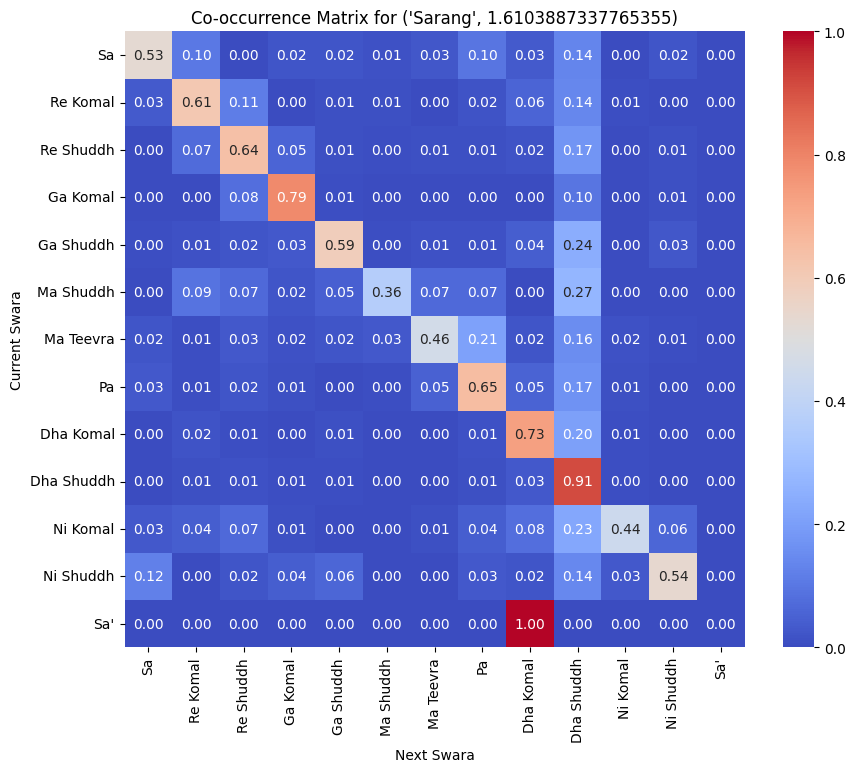

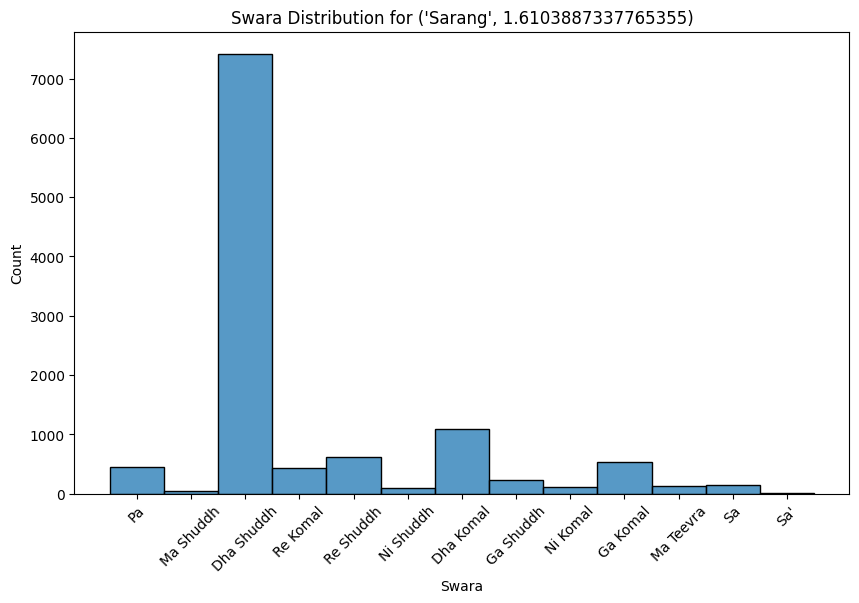

In [ ]:
process_and_visualize(new_audio_file, classified_raga)